In [2]:
import numpy as np
from numba import jit, njit


In [3]:
def pairwize(array):
    return np.transpose(np.stack([np.roll(array, -i) for i in range(2)]))

def fitness(solution, distance):
    cost = 0
    pairs = pairwize(solution)
    for edge in pairs:
        cost += distance[tuple(edge)]
    return cost 

def get_travel(solution, city_points):
    travel = []
    for v in solution:
        travel.append(city_points[v])
    travel.append(city_points[solution[0]])
    return np.array(travel)

def init_tsp(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2) * 100.0

    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
                
    #np.fill_diagonal(distances, 0.000000000000001)
    return cities, distances

def init_tsp_circular(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)
    cities[:,0] = np.cos(np.linspace(0, 2*np.pi, NB_CITIES))
    cities[:,1] = np.sin(np.linspace(0, 2*np.pi, NB_CITIES))
    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
                
    #np.fill_diagonal(distances, 0.000000000000001)
    return cities, distances

def get_random_solution(NB_CITIES):
    solution=(list(range(NB_CITIES)))
    return np.random.shuffle(solution)

def plot_solution(solution, color='b'):
    import matplotlib.pyplot as plt
    from copy import deepcopy
    x, y = zip(*get_travel(solution, deepcopy(cities)))
    plt.plot(x,y, color=color)
    x, y = zip(*cities)
    plt.scatter(x, y, marker='*') 
@jit
def getP(visibility, pheromones, alpha=1, beta=1):
    return np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)) / \
        np.sum(np.multiply(np.power(visibility, alpha), np.power(pheromones, beta)))

def P_i(i, visibility, pheromones, alpha=1, beta=1):
    return getP(visibility[i], pheromones[i], alpha=alpha, beta=beta)
@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]
@jit(nopython=True)
def select(P):
    if len(P)==1:
        return 0
    return rand_choice_nb(np.arange(len(P)), p=P)

@njit
def produce_ant_path(distances, pheromones, alpha, beta):
    NB_CITIES=len(distances)
    v = 1 / distances
    s = np.random.randint(NB_CITIES)
    solution = np.zeros(NB_CITIES)
    v[:, s] = 0
    solution[0] = s
    for i in range(1, NB_CITIES):
        p = getP(v[s], pheromones[s], alpha=alpha, beta=beta)
        v[s, :] = 0
        s = rand_choice_nb(np.arange(len(p)), p)
        v[:, s] = 0
        solution[i] = s
    return solution

/home/xetql/.local/share/virtualenvs/TSP-AC-Sz05brbq/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


335.5118585359144
[6. 3. 1. 5. 9. 7. 0. 8. 2. 4.]


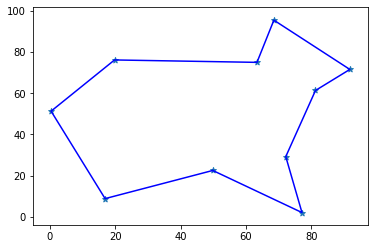

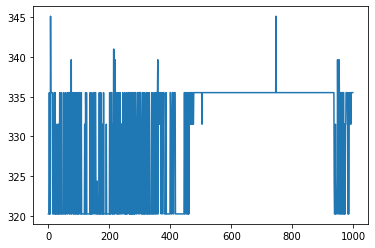

In [10]:
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed


NB_CITIES=10
NB_ANTS  =10
NB_ITER  =1000
np.random.seed(10)
cities, distances = init_tsp(NB_CITIES)
visibility = 1 / distances
np.fill_diagonal(visibility, 0)
pheromones = np.ones_like(visibility)
np.fill_diagonal(pheromones, 0)
evaporation = 0.5
Q = 1
L = np.zeros(NB_ANTS)
fit=[]

v = np.copy(visibility)
s = np.random.randint(NB_CITIES)
solution = np.zeros(NB_CITIES)

v[:, s] = 0
solution[0] = s
for i in range(1, NB_CITIES):
    s = np.argmax(v[s])
    v[:, s] = 0
    solution[i] = s
pheromones = np.ones_like(visibility) / fitness(solution.astype(int), distances)
best_overall_fitness = np.Inf
best_overall_solution= []
for iteration in range(NB_ITER):
    solutions = np.zeros((NB_ANTS,NB_CITIES))
    
    for ant in range(NB_ANTS):
        solutions[ant] = produce_ant_path(np.copy(distances), np.copy(pheromones), 5, 1)
        
    L = np.apply_along_axis(fitness, 1, solutions.astype(int), distance=distances)
    
    pheromones = evaporation * pheromones
    
    for ant in range(NB_ANTS):
        for edge in pairwize(solutions[ant]):
            pheromones[tuple(edge.astype(int))]       += 1 / L[ant]
            pheromones[tuple(edge[::-1].astype(int))] += 1 / L[ant]
            
    best = np.argmin(L)
    if best_overall_fitness > L[best]:
        best_overall_fitness = L[best]
        best_overall_solution= solutions[best]
    fit.append(L[best])
plot_solution(best_overall_solution.astype(int))
plt.figure()
plt.plot(fit)
print(np.min(L))
print(solutions[best])

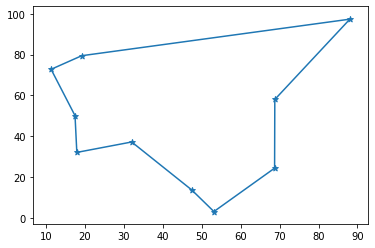

In [35]:
from itertools import permutations
arr = np.asarray(list(permutations(np.arange(NB_CITIES))))
fitnesses = np.apply_along_axis(fitness, 1, arr, distance=distances)
best = np.argmin(fitnesses)
plot_solution(arr[best].astype(int))

s1:  422.47725769753015
s2:  410.0233955739209


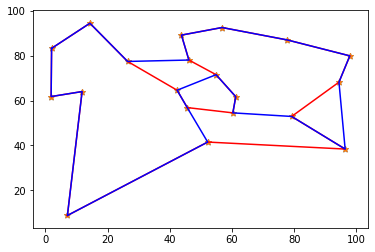

In [43]:
from io import StringIO
s1 = np.loadtxt(StringIO('7. 12. 17.  8. 13. 15.  2. 16.  1. 18.  0. 11.  3.  6.  9. 10. 19.  5. 4. 14.')).astype(int)
s2 = np.loadtxt(StringIO('8. 13. 15. 11.  3.  6.  9. 10. 19.  4.  5.  1. 18.  0.  2. 16. 14.  7. 12. 17.')).astype(int)
print('s1: ', fitness(s1, distances))
print('s2: ', fitness(s2, distances))

plot_solution(s1, 'r')
plot_solution(s2, 'b')



In [ ]:
#fitnesses = np.apply_along_axis(fitness, axis=1, arr=solutions.astype(int), distance=distances)


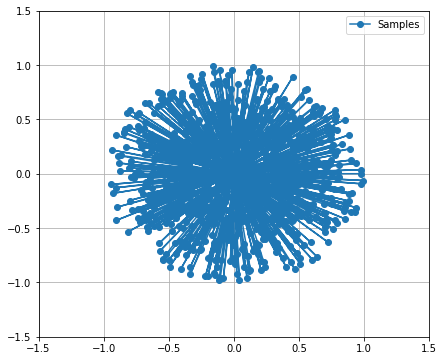

In [67]:
# generate random points in a circle

import numpy as np 
import pylab as plt 


num_samples = 1000

# make a simple unit circle 
theta = np.linspace(0, 2*np.pi, num_samples)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)

# generate the points
# theta = np.random.rand((num_samples)) * (2 * np.pi)
r = np.random.rand((num_samples))
x, y = r * np.cos(theta), r * np.sin(theta)

# plots
plt.figure(figsize=(7,6))
plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
plt.plot(x, y, marker='o', linestyle='.', label='Samples')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.grid()
plt.legend(loc='upper right')
plt.show(block=True)

In [ ]:
    """for ant in range(NB_ANTS):
        v = np.copy(visibility)
        s = np.random.randint(NB_CITIES)
        solution = np.zeros(NB_CITIES)
        v[:, s] = 0
        solution[0] = s
        for i in range(1, NB_CITIES):
            p = getP(v[s], pheromones[s], alpha=1, beta=2)
            v[s, :] = 0
            s = select(p)
            v[:, s] = 0
            solution[i] = s
        solutions[ant]  = solution
        L[ant] = fitness(solution.astype(int), distances)"""